Geoinformatik 2 – GIS-Analyse
# Übung 8: Punktmusteranalyse mit Ripley Funktionen
Prof. Dr. Yu Feng

## Lernziele
- Vier verschiedene räumliche Punktmuster generieren (Cluster, Zwischenmuster, Regulär, Zufällig)
- Ripley's G, F, K, L Funktionen berechnen und interpretieren
- Räumliche Muster mittels Ripley-Funktionenfamilie vergleichen

In [1]:
import numpy
import matplotlib.pyplot as plt
import seaborn
from pointpats import distance_statistics

# Set random seed for reproducibility
numpy.random.seed(42)

## Generierung von vier räumlichen Verteilungsmustern

Wir werden vier verschiedene Punktmuster generieren:
1. **Cluster-Muster (Clustered)** - Hochgradig geclusterte Punktgruppen
2. **Zwischenmuster (Intermediate)** - Poisson-Clusterprozess mit mittlerer Clusterungstendenz
3. **Regelmäßiges Muster (Regular)** - Gleichmäßig verteiltes Gitter
4. **Zufälliges Muster (Random)** - Vollständig räumlicher Zufallsprozess (CSR)

In [17]:
# Definiere Bounding Box des Studiengebiets - Quadratischer Bereich 200km × 200km
x_min, x_max = 0, 200000
y_min, y_max = 0, 200000

# 1. Cluster-Muster - Hochgradig geclusterte Punkte um mehrere Zentren (starke Clusterung)
n_points = 300
n_clusters_clustered = 5
clustured_centers = numpy.random.uniform([x_min, y_min], [x_max, y_max], size=(n_clusters_clustered, 2))
clustured_points = []
for center in clustured_centers:
    # Sehr kleine Standardabweichung - starke Clusterung
    cluster_pts = center + numpy.random.normal(0, 5000, size=(n_points // n_clusters_clustered, 2))
    clustured_points.extend(cluster_pts)
coordinates = numpy.array(clustured_points)
print(f"Cluster-Muster generiert mit {len(coordinates)} Punkten (σ=5km, 5 Cluster)")

# 2. Zwischenmuster - Poisson-Clusterprozess (mittlere Clusterung)
n_clusters_intermediate = 6
cluster_radius = 15000  # Clusterungs-Radius für mittleres Muster
intermediate_centers = numpy.random.uniform([x_min, y_min], [x_max, y_max], size=(n_clusters_intermediate, 2))
intermediate_points = []
for center in intermediate_centers:
    cluster_pts = center + numpy.random.normal(0, cluster_radius, size=(n_points // n_clusters_intermediate, 2))
    intermediate_points.extend(cluster_pts)
intermediate_pattern = numpy.array(intermediate_points)
print(f"Zwischenmuster generiert mit {len(intermediate_pattern)} Punkten (σ=15km, 6 Cluster)")

# 3. Regelmäßiges Muster - Gleichmäßiges Gitter + kleine Rauschkomponente
n_grid = int(numpy.sqrt(n_points))
x_regular = numpy.linspace(x_min, x_max, n_grid)
y_regular = numpy.linspace(y_min, y_max, n_grid)
xx, yy = numpy.meshgrid(x_regular, y_regular)
regular_pattern = numpy.column_stack([xx.ravel(), yy.ravel()])[:n_points]
# Kleine Rausch-Komponente hinzufügen, um perfekte Regelmäßigkeit zu brechen (±2000m)
noise = numpy.random.normal(0, 2000, size=regular_pattern.shape)
regular_pattern = regular_pattern + noise
print(f"Regelmäßiges Muster generiert mit {len(regular_pattern)} Punkten (zufällig verteiltes Gitter, σ=2km Rauschen)")

# 4. Zufälliges Muster - Vollständig räumlicher Zufallsprozess (CSR)
random_pattern = numpy.random.uniform([x_min, y_min], [x_max, y_max], size=(n_points, 2))
print(f"Zufälliges Muster generiert mit {len(random_pattern)} Punkten")

Cluster-Muster generiert mit 300 Punkten (σ=5km, 5 Cluster)
Zwischenmuster generiert mit 300 Punkten (σ=15km, 6 Cluster)
Regelmäßiges Muster generiert mit 289 Punkten (zufällig verteiltes Gitter, σ=2km Rauschen)
Zufälliges Muster generiert mit 300 Punkten


## Visualisierung der vier Verteilungsmuster

Darstellung der räumlichen Verteilung aller vier Muster in einem 2×2-Untergitterdiagramm.

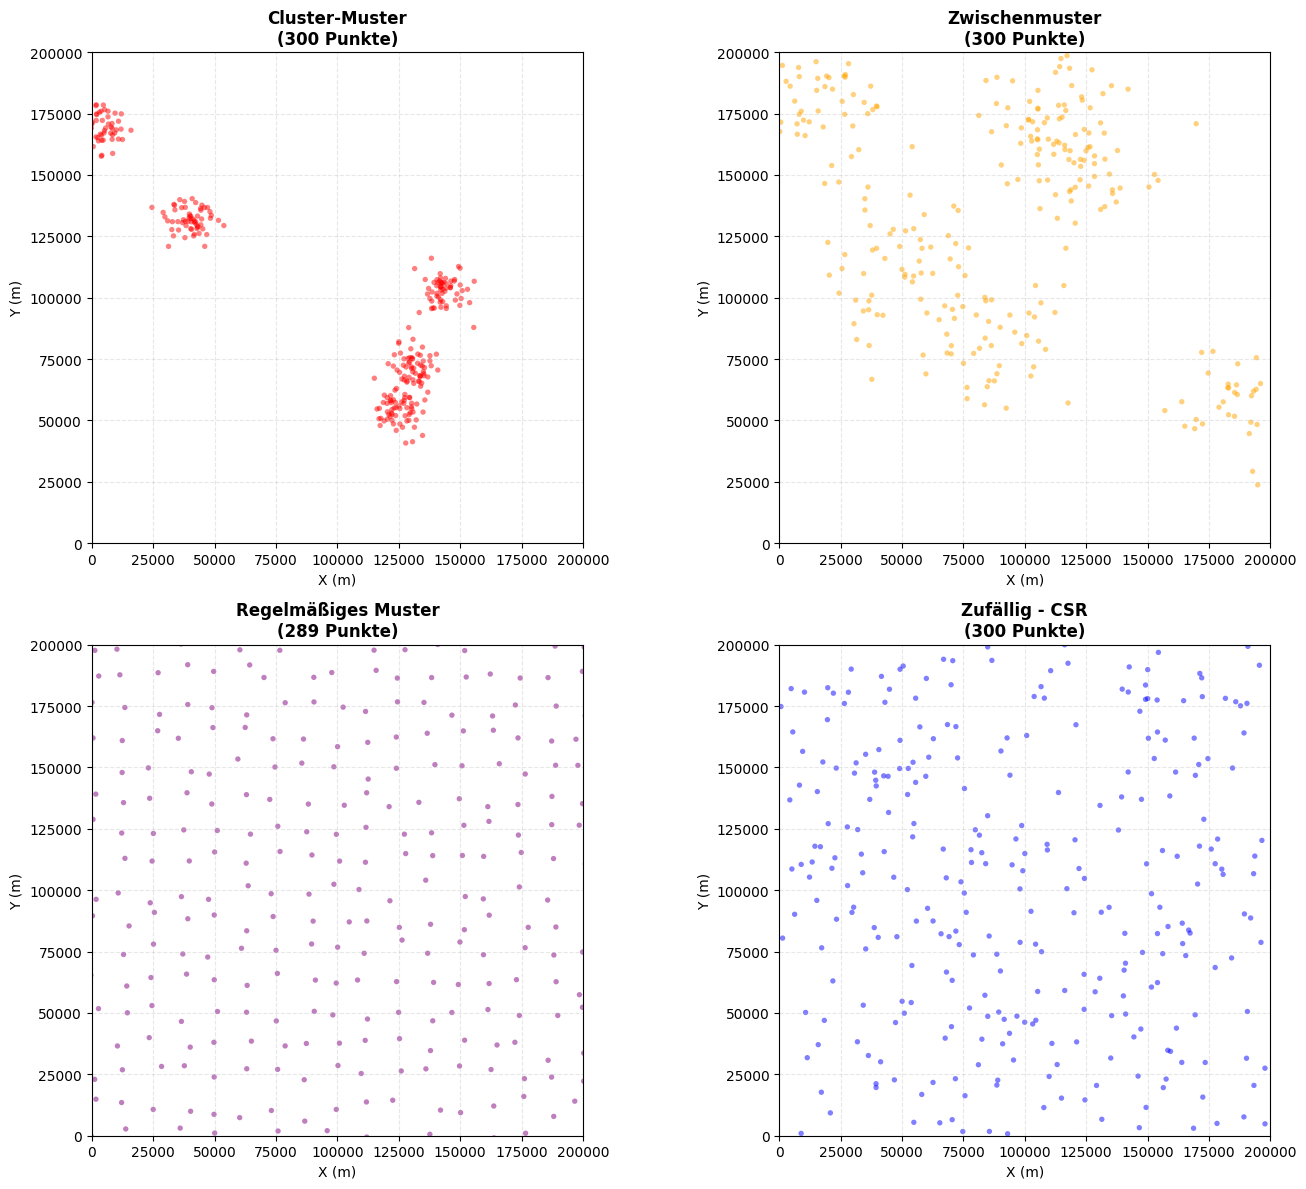


=== Zusammenfassung der Muster ===
Cluster-Muster:     300 Punkte - Starke Clusterung
Zwischenmuster:     300 Punkte - Mittlere Clusterung
Regelmäßig:         289 Punkte - Gleichmäßige Verteilung
Zufällig:           300 Punkte - Vollständig räumliche Zufälligkeit


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

patterns = [
    (coordinates, "Cluster-Muster", "red", axes[0, 0]),
    (intermediate_pattern, "Zwischenmuster", "orange", axes[0, 1]),
    (regular_pattern, "Regelmäßiges Muster", "purple", axes[1, 0]),
    (random_pattern, "Zufällig - CSR", "blue", axes[1, 1])
]

for points, title, color, ax in patterns:
    ax.scatter(points[:, 0], points[:, 1], alpha=0.5, s=15, color=color, edgecolors='none')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.set_xlabel('X (m)', fontsize=10)
    ax.set_ylabel('Y (m)', fontsize=10)
    ax.set_title(f'{title}\n({len(points)} Punkte)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('four_patterns_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Zusammenfassung der Muster ===")
print(f"Cluster-Muster:   {len(coordinates):5d} Punkte - Starke Clusterung")
print(f"Zwischenmuster:   {len(intermediate_pattern):5d} Punkte - Mittlere Clusterung")
print(f"Regelmäßig:       {len(regular_pattern):5d} Punkte - Gleichmäßige Verteilung")
print(f"Zufällig:         {len(random_pattern):5d} Punkte - Vollständig räumliche Zufälligkeit")

## Vergleich der Ripley G-Funktion

Die G-Funktion analysiert die Wahrscheinlichkeitsverteilung der nächsten Nachbarn-Entfernungen. Anstiegsgeschwindigkeit von G(d):
- **Schneller Anstieg** → Cluster-Muster
- **Langsamer Anstieg** → Regelmäßiges/verteiltes Muster
- **Moderater Anstieg** → Zufälliges Muster

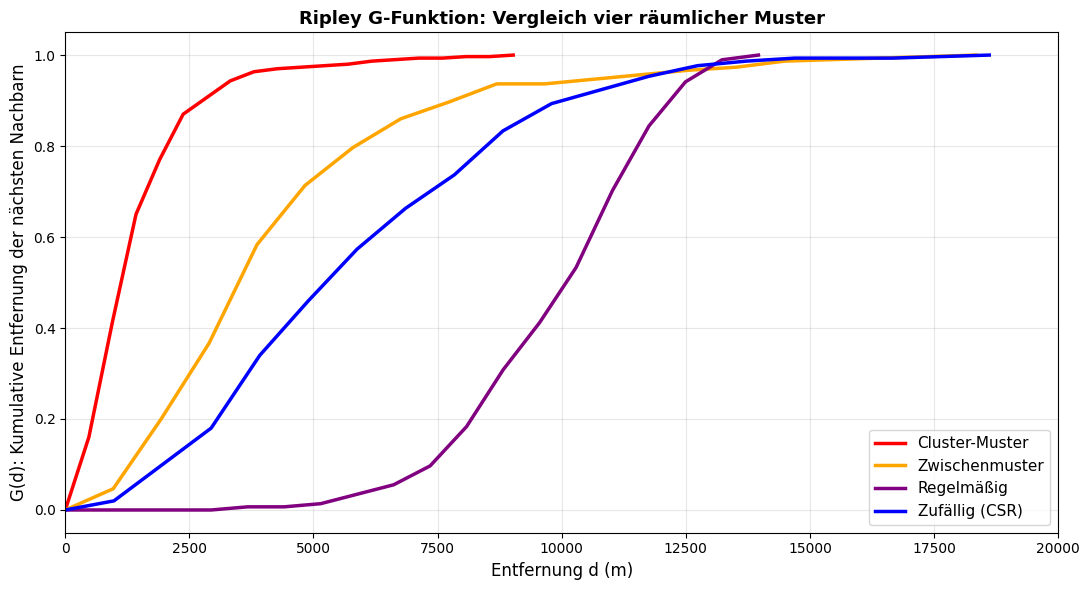


G-Funktions-Interpretation:
  Cluster-Muster:  G steigt schnell an    → viele Punkte eng beisammen
  Zwischenmuster:  G steigt moderat an    → einige Clusterung
  Regelmäßig:      G steigt langsam an    → Punkte gleichmäßig verteilt
  Zufällig:        G steigt schrittweise an → räumlich zufällig


In [4]:
# Berechne G-Funktion für alle vier Muster
g_clustered = distance_statistics.g_test(coordinates, support=20, keep_simulations=False)
g_intermediate = distance_statistics.g_test(intermediate_pattern, support=20, keep_simulations=False)
g_regular = distance_statistics.g_test(regular_pattern, support=20, keep_simulations=False)
g_random = distance_statistics.g_test(random_pattern, support=20, keep_simulations=False)

# Plotte Vergleich
fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(g_clustered.support, g_clustered.statistic, 
        label="Cluster-Muster", color="red", linewidth=2.5)
ax.plot(g_intermediate.support, g_intermediate.statistic,
        label="Zwischenmuster", color="orange", linewidth=2.5)
ax.plot(g_regular.support, g_regular.statistic,
        label="Regelmäßig", color="purple", linewidth=2.5)
ax.plot(g_random.support, g_random.statistic,
        label="Zufällig (CSR)", color="blue", linewidth=2.5)

ax.set_xlabel("Entfernung d (m)", fontsize=12)
ax.set_ylabel("G(d): Kumulative Entfernung der nächsten Nachbarn", fontsize=12)
ax.set_title("Ripley G-Funktion: Vergleich vier räumlicher Muster", fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.set_xlim(0, 20000)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ripley_g_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nG-Funktions-Interpretation:")
print("  Cluster-Muster:  G steigt schnell an    → viele Punkte eng beisammen")
print("  Zwischenmuster:  G steigt moderat an    → einige Clusterung")
print("  Regelmäßig:      G steigt langsam an    → Punkte gleichmäßig verteilt")
print("  Zufällig:        G steigt schrittweise an → räumlich zufällig")

## Vergleich der Ripley F-Funktion

Die F-Funktion (Empty-Space-Funktion) analysiert die Entfernung von zufälligen Punkten zum nächsten Musterpunkt. Anstiegsgeschwindigkeit von F(d):
- **Langsamer Anstieg** → Große Lücken (Clusterung)
- **Schneller Anstieg** → Keine markanten Lücken (Verteiltheit)

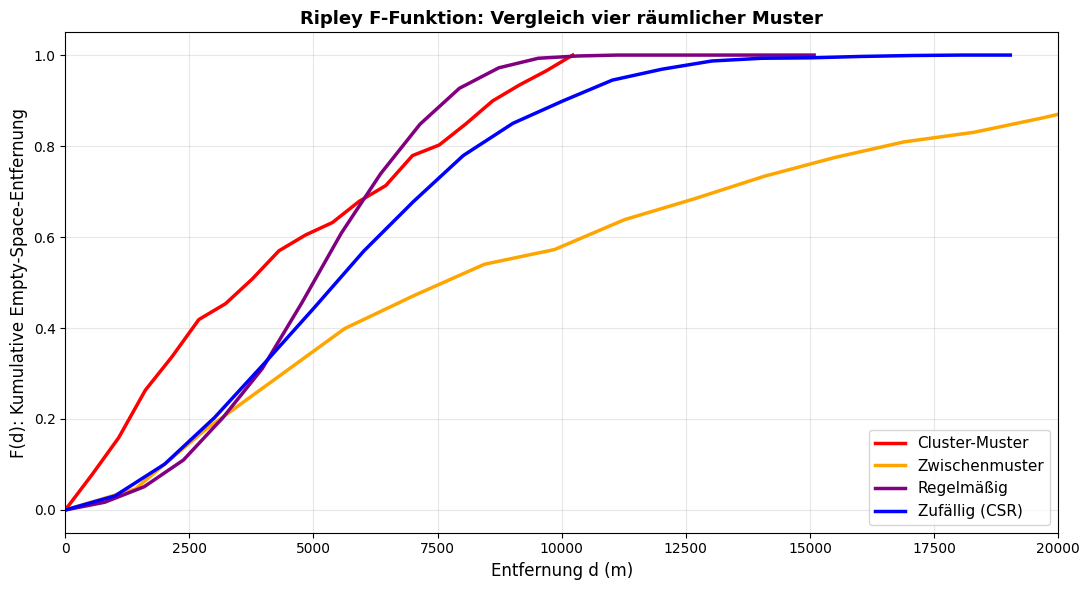


F-Funktions-Interpretation:
  Cluster-Muster:  F steigt langsam an    → große Lücken zwischen Clustern
  Zwischenmuster:  F steigt moderat an    → einige Lücken vorhanden
  Regelmäßig:      F steigt schnell an    → gleichmäßiger Abstand, minimale Lücken
  Zufällig:        F steigt schrittweise an → intermediate Lückenverteilung


In [21]:
# Definiere die Bounding Box (200km × 200km) als Polygon für Ripley-Funktionen
from shapely.geometry import box
bbox_polygon = box(x_min, y_min, x_max, y_max)

# Berechne F-Funktion für alle vier Muster mit definierter Bounding Box
f_clustered = distance_statistics.f_test(coordinates, support=20, hull=bbox_polygon, keep_simulations=False)
f_intermediate = distance_statistics.f_test(intermediate_pattern, support=20, hull=bbox_polygon, keep_simulations=False)
f_regular = distance_statistics.f_test(regular_pattern, support=20, hull=bbox_polygon, keep_simulations=False)
f_random = distance_statistics.f_test(random_pattern, support=20, hull=bbox_polygon, keep_simulations=False)

# Plotte Vergleich
fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(f_clustered.support, f_clustered.statistic,
        label="Cluster-Muster", color="red", linewidth=2.5)
ax.plot(f_intermediate.support, f_intermediate.statistic,
        label="Zwischenmuster", color="orange", linewidth=2.5)
ax.plot(f_regular.support, f_regular.statistic,
        label="Regelmäßig", color="purple", linewidth=2.5)
ax.plot(f_random.support, f_random.statistic,
        label="Zufällig (CSR)", color="blue", linewidth=2.5)

ax.set_xlabel("Entfernung d (m)", fontsize=12)
ax.set_ylabel("F(d): Kumulative Empty-Space-Entfernung", fontsize=12)
ax.set_title("Ripley F-Funktion: Vergleich vier räumlicher Muster", fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.set_xlim(0, 20000)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ripley_f_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nF-Funktions-Interpretation:")
print("  Cluster-Muster:  F steigt langsam an    → große Lücken zwischen Clustern")
print("  Zwischenmuster:  F steigt moderat an    → einige Lücken vorhanden")
print("  Regelmäßig:      F steigt schnell an    → gleichmäßiger Abstand, minimale Lücken")
print("  Zufällig:        F steigt schrittweise an → intermediate Lückenverteilung")

## Vergleich der Ripley K-Funktion

Die K-Funktion zählt die Anzahl der Punktpaare innerhalb der Entfernung d. Vergleich mit dem theoretischen Erwartungswert $K_{CSR}(d) = \pi d^2$:
- $K(d) > \pi d^2$ → Clusterung
- $K(d) = \pi d^2$ → Zufällig
- $K(d) < \pi d^2$ → Regelmäßig/verteilt

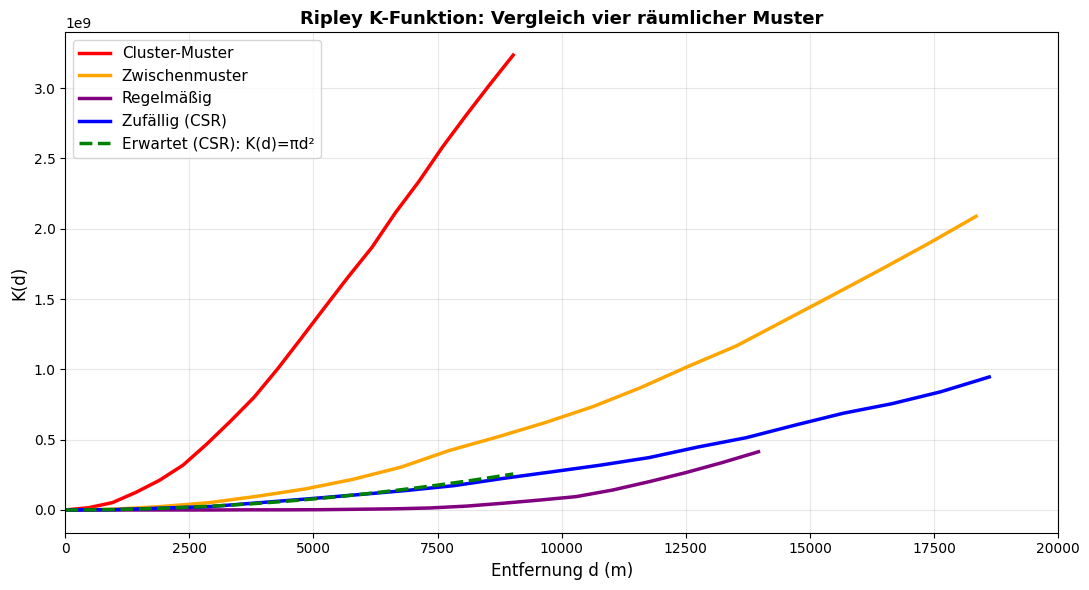


K-Funktions-Interpretation:
  Cluster-Muster:  K >> erwartet     → starke Clusterung bei allen Entfernungen
  Zwischenmuster:  K leicht > Erw.  → mittlere Clusterung
  Regelmäßig:      K << erwartet    → regelmäßiger Abstand (Verteiltheit)
  Zufällig:        K ≈ erwartet     → räumliche Zufälligkeit (CSR)


In [6]:
# Berechne K-Funktion für alle vier Muster
k_clustered = distance_statistics.k_test(coordinates, support=20, keep_simulations=False)
k_intermediate = distance_statistics.k_test(intermediate_pattern, support=20, keep_simulations=False)
k_regular = distance_statistics.k_test(regular_pattern, support=20, keep_simulations=False)
k_random = distance_statistics.k_test(random_pattern, support=20, keep_simulations=False)

# Plotte Vergleich
fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(k_clustered.support, k_clustered.statistic,
        label="Cluster-Muster", color="red", linewidth=2.5)
ax.plot(k_intermediate.support, k_intermediate.statistic,
        label="Zwischenmuster", color="orange", linewidth=2.5)
ax.plot(k_regular.support, k_regular.statistic,
        label="Regelmäßig", color="purple", linewidth=2.5)
ax.plot(k_random.support, k_random.statistic,
        label="Zufällig (CSR)", color="blue", linewidth=2.5)

# Füge theoretischen Erwartungswert für CSR hinzu: K(d) = π d²
expected = numpy.pi * k_clustered.support ** 2
ax.plot(k_clustered.support, expected, label="Erwartet (CSR): K(d)=πd²",
        color="green", linestyle="--", linewidth=2.5)

ax.set_xlabel("Entfernung d (m)", fontsize=12)
ax.set_ylabel("K(d)", fontsize=12)
ax.set_title("Ripley K-Funktion: Vergleich vier räumlicher Muster", fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.set_xlim(0, 20000)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ripley_k_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nK-Funktions-Interpretation:")
print("  Cluster-Muster:  K >> erwartet     → starke Clusterung bei allen Entfernungen")
print("  Zwischenmuster:  K leicht > Erw.  → mittlere Clusterung")
print("  Regelmäßig:      K << erwartet    → regelmäßiger Abstand (Verteiltheit)")
print("  Zufällig:        K ≈ erwartet     → räumliche Zufälligkeit (CSR)")

## Vergleich der Ripley L-Funktion

Die L-Funktion ist die normalisierte K-Funktion: $L(d) = \sqrt{K(d)/\pi}$
- Für CSR ist der Erwartungswert $L(d) = d$
- $L(d) > d$ → Clusterung
- $L(d) = d$ → Zufällig
- $L(d) < d$ → Regelmäßig/verteilt

Die L-Funktion ist leichter zu interpretieren als die K-Funktion.

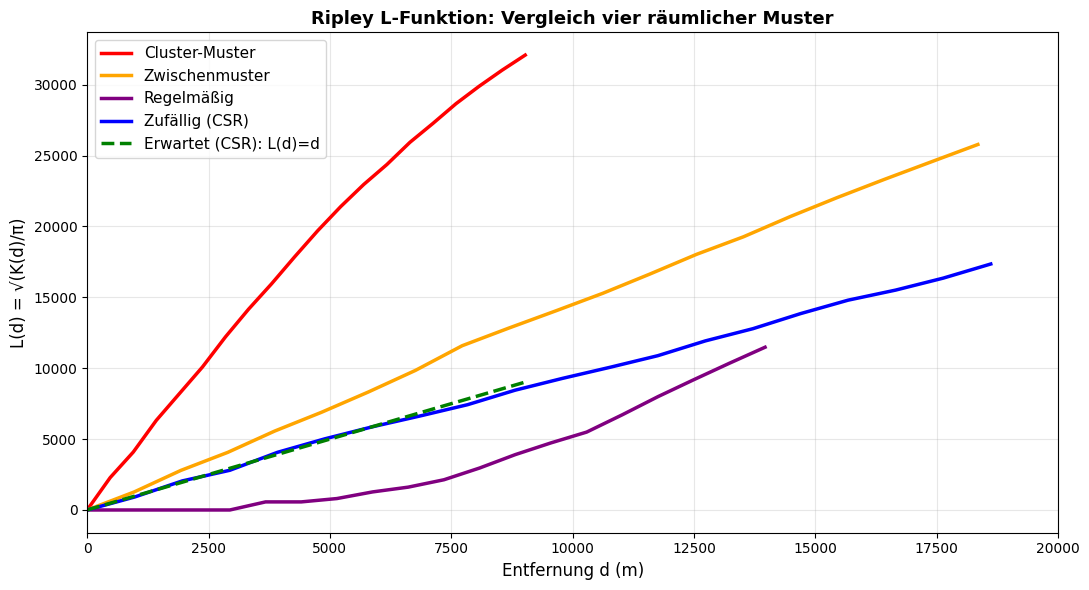


L-Funktions-Interpretation (leichter zu lesen als K):
  Wenn L(d) > d: Clusterung bei Entfernung d
  Wenn L(d) = d: zufälliges Muster (CSR-Erwartung)
  Wenn L(d) < d: Regelmäßigkeit/Verteiltheit bei Entfernung d

Beobachtete Muster:
  Cluster-Muster:  L >> d bei allen Entfernungen     → starke Clusterung
  Zwischenmuster:  L leicht > d                      → mittlere Clusterung
  Regelmäßig:      L << d                            → regelmäßiger Abstand (stärkst verteilt)
  Zufällig:        L ≈ d                             → entspricht CSR-Erwartung


In [7]:
# Berechne L-Funktion für alle vier Muster
# L(d) = sqrt(K(d)/π)
l_clustered = numpy.sqrt(k_clustered.statistic / numpy.pi)
l_intermediate = numpy.sqrt(k_intermediate.statistic / numpy.pi)
l_regular = numpy.sqrt(k_regular.statistic / numpy.pi)
l_random = numpy.sqrt(k_random.statistic / numpy.pi)

# Plotte Vergleich
fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(k_clustered.support, l_clustered,
        label="Cluster-Muster", color="red", linewidth=2.5)
ax.plot(k_intermediate.support, l_intermediate,
        label="Zwischenmuster", color="orange", linewidth=2.5)
ax.plot(k_regular.support, l_regular,
        label="Regelmäßig", color="purple", linewidth=2.5)
ax.plot(k_random.support, l_random,
        label="Zufällig (CSR)", color="blue", linewidth=2.5)

# Füge theoretischen Erwartungswert für CSR hinzu: L(d) = d
ax.plot(k_clustered.support, k_clustered.support, label="Erwartet (CSR): L(d)=d",
        color="green", linestyle="--", linewidth=2.5)

ax.set_xlabel("Entfernung d (m)", fontsize=12)
ax.set_ylabel("L(d) = √(K(d)/π)", fontsize=12)
ax.set_title("Ripley L-Funktion: Vergleich vier räumlicher Muster", fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.set_xlim(0, 20000)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ripley_l_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nL-Funktions-Interpretation (leichter zu lesen als K):")
print("  Wenn L(d) > d: Clusterung bei Entfernung d")
print("  Wenn L(d) = d: zufälliges Muster (CSR-Erwartung)")
print("  Wenn L(d) < d: Regelmäßigkeit/Verteiltheit bei Entfernung d")
print("\nBeobachtete Muster:")
print("  Cluster-Muster:  L >> d bei allen Entfernungen     → starke Clusterung")
print("  Zwischenmuster:  L leicht > d                      → mittlere Clusterung")
print("  Regelmäßig:      L << d                            → regelmäßiger Abstand (stärkst verteilt)")
print("  Zufällig:        L ≈ d                             → entspricht CSR-Erwartung")

## Referenz
- Point Pattern Analysis — Geographic Data Science with Python (https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html)
- distance_statistics (https://pysal.org/notebooks/explore/pointpats/distance_statistics.html)